In [188]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

asset_dir = '../Assets/freq_noise/'

# Butterworth Notch Reject Filter of order n

• Butterworth Highpass filter:

$$H_{NR}(u,v) = \prod_{k=1}^{Q} \left[\frac{1}{1+\left[\frac{D_{0k}}{D_k(u,v)}\right]^{2n}}\right] \left[\frac{1}{1+\left[\frac{D_{0k}}{D_{-k}(u,v)}\right]^{2n}}\right]$$

• The distance computations for each filter transfer function

$$D_k(u,v) = \left[\left(u - \frac{M}{2} - u_k\right)^2 + \left(v - \frac{N}{2} - v_k\right)^2\right]^{1/2}$$

$$D_{-k}(u,v) = \left[\left(u - \frac{M}{2} + u_k\right)^2 + \left(v - \frac{N}{2} + v_k\right)^2\right]^{1/2}$$

Where, center of the frequency rectangle = $(M/2, N/2)$

$D_k(u,v)$ = Distance of a pixel from center

$D_{0k}$ = cut-off frequency of k-th notch pair

$(u,v)$ = peaks in the frequency domain to be removed


In [189]:
def calculate_distance(u, v, M, N, notch_u, notch_v):
    center_u = M / 2
    center_v = N / 2
    uk = notch_u - center_u
    vk = notch_v - center_v

    # D_-k(u,v) = [(u - M/2 + uk)^2 + (v - N/2 + vk)^2]^(1/2)
    Dk_neg = np.sqrt((u - center_u + uk)**2 + (v - center_v + vk)**2)
    # D_k(u,v) = [(u - M/2 - uk)^2 + (v - N/2 - vk)^2]^(1/2)
    Dk = np.sqrt((u - center_u - uk)**2 + (v - center_v - vk)**2)

    return Dk, Dk_neg

In [190]:
def calculate_HNR(u, v, M, N, uk, vk, D0k, n):
    Dk, D_neg_k = calculate_distance(u, v, M, N, uk, vk)

    # div by zero prevention
    Dk = np.where(Dk == 0, 1e-10, Dk)
    D_neg_k = np.where(D_neg_k == 0, 1e-10, D_neg_k)

    # H1 = 1/(1 + (D0k/Dk)^(2n))
    H1 = 1.0 / (1.0 + (D0k / (Dk))**(2 * n))
    
    # H2 = 1/(1 + (D0k/D_-k)^(2n))
    H2 = 1.0 / (1.0 + (D0k / (D_neg_k))**(2 * n))

    HNR = H1 * H2
    
    return HNR

In [191]:
def gen_mask(img_shape, notch_pairs, D0k, n):
    M, N = img_shape
    
    u = np.arange(M)
    v = np.arange(N)
    u, v = np.meshgrid(u, v)
    
    mask = np.ones((M, N), dtype=np.float64)
    
    for uk, vk in notch_pairs:
        HNR = calculate_HNR(u, v, M, N, uk, vk, D0k, n)
        mask *= HNR
    
    return mask

In [192]:
img_input = cv2.imread(asset_dir+'two_noise.jpg', 0)
img = img_input.copy()
image_size = img.shape[0] * img.shape[1]

In [193]:
notch_pairs = [(272,256), (261,261)]
D0k_1 = 20
n_1 = 2

D0k_2 = 5
n_2 = 2

mask_1 = gen_mask(img.shape, notch_pairs, D0k_1, n_1)
mask_2 = gen_mask(img.shape, notch_pairs, D0k_2, n_2)

In [194]:
ft = np.fft.fft2(img)
ft_shift = np.fft.fftshift(ft)
magnitude_spectrum_ac = np.abs(ft_shift)
magnitude_spectrum = 20 * np.log(np.abs(ft_shift)+1)
magnitude_spectrum = cv2.normalize(magnitude_spectrum, None,0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U) 
ang = np.angle(ft_shift)
ang_ = cv2.normalize(ang, None,0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U) 

magnitude_spectrum_ac[272,256] = 0
magnitude_spectrum_ac[240,256] = 0
magnitude_spectrum_ac[261,261] = 0
magnitude_spectrum_ac[251,251] = 0

magnitude_spectrum_ac_1 = magnitude_spectrum_ac * mask_1
magnitude_spectrum_ac_2 = magnitude_spectrum_ac * mask_2

## phase add F(u,v)=∣F(u,v)∣*e^jθ(u,v)
final_result_1 = np.multiply(magnitude_spectrum_ac_1, np.exp(1j*ang))
final_result_2 = np.multiply(magnitude_spectrum_ac_2, np.exp(1j*ang))

# inverse fourier
img_back_1 = np.real(np.fft.ifft2(np.fft.ifftshift(final_result_1)))
img_back_2 = np.real(np.fft.ifft2(np.fft.ifftshift(final_result_2)))

img_back_scaled_1 = cv2.normalize(img_back_1, None, 0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U)
img_back_scaled_2 = cv2.normalize(img_back_2, None, 0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U)
mask_1 = cv2.normalize(mask_1, None,0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U)
mask_2 = cv2.normalize(mask_2, None,0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U)

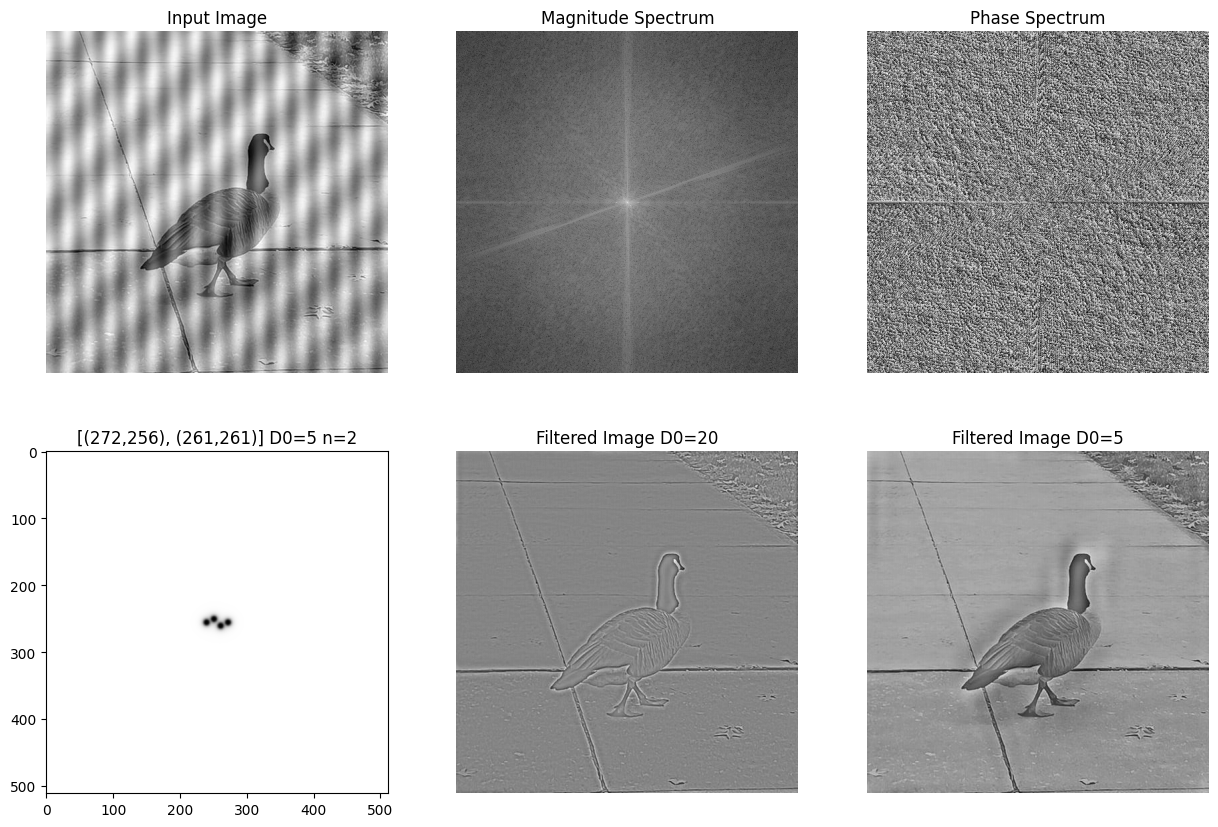

In [195]:
fig, axs = plt.subplots(2,3, figsize=(15,10))

for ax in axs.flat:
    ax.axis('off')
    
axs[0,0].imshow(img_input, cmap='gray')
axs[0,0].set_title('Input Image')
axs[0,1].imshow(magnitude_spectrum, cmap='gray')
axs[0,1].set_title('Magnitude Spectrum')
axs[0,2].imshow(ang_, cmap='gray')
axs[0,2].set_title('Phase Spectrum')
axs[1,0].imshow(mask_2, cmap='gray')
axs[1,0].set_title('[(272,256), (261,261)] D0=5 n=2')
axs[1,0].axis('on')
axs[1,1].imshow(img_back_scaled_1, cmap='gray')
axs[1,1].set_title('Filtered Image D0=20')
axs[1,2].imshow(img_back_scaled_2, cmap='gray')
axs[1,2].set_title('Filtered Image D0=5')



plt.show()


# Ideal Notch Reject Filter

• The general form of Ideal Highpass filter:

$$H(u,v) = \begin{cases} 0 \text{ if } D(u,v) \leq D_0 \\ 1 \text{ if } D(u,v) > D_0 \end{cases}$$

The distance computations for each filter transfer function

$$D_k(u,v) = \left[\left(u - \frac{M}{2} - u_k\right)^2 + \left(v - \frac{N}{2} - v_k\right)^2\right]^{1/2}$$

$$D_{-k}(u,v) = \left[\left(u - \frac{M}{2} + u_k\right)^2 + \left(v - \frac{N}{2} + v_k\right)^2\right]^{1/2}$$

In [196]:
def calculate_HNR_ideal(u, v, M, N, uk, vk, D0k):
    Dk, D_neg_k = calculate_distance(u, v, M, N, uk, vk)
    
    # Ideal filter: H = 0 if D <= D0, H = 1 if D > D0
    HNR = np.where((Dk <= D0k) | (D_neg_k <= D0k), 0.0, 1.0)
    
    return HNR

In [197]:
def gen_mask_ideal(img_shape, notch_pairs, D0k):
    M, N = img_shape
   
    u = np.arange(M)
    v = np.arange(N)
    u, v = np.meshgrid(u, v)
   
    mask = np.ones((M, N), dtype=np.float64)
   
    for uk, vk in notch_pairs:
        HNR = calculate_HNR_ideal(u, v, M, N, uk, vk, D0k)
        mask *= HNR
   
    return mask

In [198]:
img_input = cv2.imread(asset_dir+'single_noise.jpg', 0)
img = img_input.copy()
image_size = img.shape[0] * img.shape[1]

In [199]:
notch_pairs = [(261,261)]
D0k_1 = 1
D0k_2 = 5

mask_1 = gen_mask_ideal(img.shape, notch_pairs, D0k_1)
mask_2 = gen_mask_ideal(img.shape, notch_pairs, D0k_2)

In [200]:
ft = np.fft.fft2(img)
ft_shift = np.fft.fftshift(ft)
magnitude_spectrum_ac = np.abs(ft_shift)
magnitude_spectrum = 20 * np.log(np.abs(ft_shift)+1)
magnitude_spectrum = cv2.normalize(magnitude_spectrum, None,0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U) 
ang = np.angle(ft_shift)
ang_ = cv2.normalize(ang, None,0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U) 

magnitude_spectrum_ac[261,261] = 0
magnitude_spectrum_ac[251,251] = 0

magnitude_spectrum_ac_1 = magnitude_spectrum_ac * mask_1
magnitude_spectrum_ac_2 = magnitude_spectrum_ac * mask_2

## phase add F(u,v)=∣F(u,v)∣*e^jθ(u,v)
final_result_1 = np.multiply(magnitude_spectrum_ac_1, np.exp(1j*ang))
final_result_2 = np.multiply(magnitude_spectrum_ac_2, np.exp(1j*ang))

# inverse fourier
img_back_1 = np.real(np.fft.ifft2(np.fft.ifftshift(final_result_1)))
img_back_2 = np.real(np.fft.ifft2(np.fft.ifftshift(final_result_2)))

img_back_scaled_1 = cv2.normalize(img_back_1, None, 0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U)
img_back_scaled_2 = cv2.normalize(img_back_2, None, 0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U)
mask_1 = cv2.normalize(mask_1, None,0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U)
mask_2 = cv2.normalize(mask_2, None,0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U)

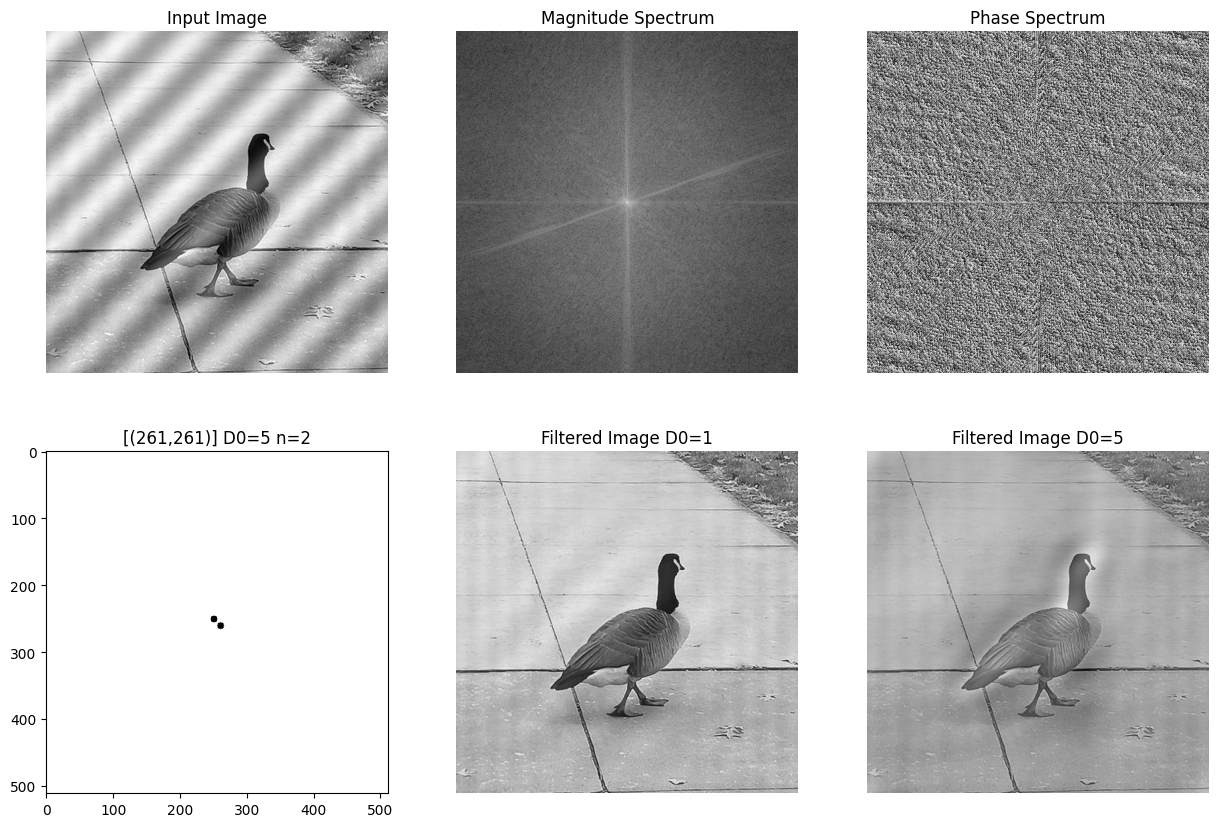

In [201]:
fig, axs = plt.subplots(2,3, figsize=(15,10))

for ax in axs.flat:
    ax.axis('off')

axs[0,0].imshow(img_input, cmap='gray')
axs[0,0].set_title('Input Image')
axs[0,1].imshow(magnitude_spectrum, cmap='gray')
axs[0,1].set_title('Magnitude Spectrum')
axs[0,2].imshow(ang_, cmap='gray')
axs[0,2].set_title('Phase Spectrum')
axs[1,0].imshow(mask_2, cmap='gray')
axs[1,0].set_title('[(261,261)] D0=5 n=2')
axs[1,0].axis('on')
axs[1,1].imshow(img_back_scaled_1, cmap='gray')
axs[1,1].set_title('Filtered Image D0=1')
axs[1,2].imshow(img_back_scaled_2, cmap='gray')
axs[1,2].set_title('Filtered Image D0=5')

plt.show()
